In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import copy
import math
import time
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
import utils
from flat_models import *

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    %load_ext autoreload
    %autoreload 2

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

# create global variables from the config
print("\n__CONFIG__")
for attribute_name in config.keys():
    print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

batch_size = probe_batch_size
num_epochs = probe_num_epochs

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    import torch.multiprocessing as mp
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier()
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = flat_flattenedprobe_MLP_nomaskeval
hcp_flat_path = /weka/proj-fmri/shared/hcp_flat
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
cls_embed = True
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
batch_size = 32
probe_batch_size = 256
num_workers = 10
num_epochs = 100
probe_num_epochs = 10
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
probe_num_samples_per_epoch = 50000
test_num_samples_per_epoch = 50000
grad_clip = 1.0
ckpt_saving = False
ckpt_interval = 20
print_interval = 20
resume_from_ckpt = True
wandb_log = True


PID of this process = 628362
device = cuda distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


# hcp_flat

In [2]:
from util.hcp_flat import load_hcp_flat_mask
from util.hcp_flat import create_hcp_flat
import util.visualize as vis

if utils.is_interactive(): # Use less samples per epoch for debugging
    probe_num_samples_per_epoch = 100000
    test_num_samples_per_epoch = 100000
    num_epochs = 10

model = mae_vit_small_patch16_fmri(
    decoder_embed_dim=decoder_embed_dim,
    t_patch_size=t_patch_size,
    pred_t_dim=pred_t_dim,
    decoder_depth=4,
    cls_embed=cls_embed,
    norm_pix_loss=norm_pix_loss,
    no_qkv_bias=no_qkv_bias,
    sep_pos_embed=sep_pos_embed,
    trunc_init=trunc_init,
)
state = torch.load("checkpoints/checkpoint-00099.pth", map_location="cpu")
model.load_state_dict(state["model"], strict=True)
print("model loaded")

model.eval()
model.requires_grad_(False)
model.to(device)
pass

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
model loaded


### Add downstream probe

In [3]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, h=256, num_classes=8):
        super(LinearProbe, self).__init__()
        # self.classifier = nn.Linear(input_dim, num_classes)
        
        # self.classifier = nn.Sequential(
        #     nn.LayerNorm(input_dim),
        #     nn.Linear(input_dim, num_classes)
        # )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.GELU(),
            nn.Dropout(p=0.15),
            nn.Linear(input_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Dropout(p=0.15),
            nn.Linear(input_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Dropout(p=0.15),
            nn.Linear(h, num_classes)
        )
    def forward(self, x):
        # x = nn.functional.normalize(x, dim=-1)
        x = self.classifier(x)
        return x

In [4]:
unique_subjects = torch.load("unique_subjects.pt")
print("len(unique_subjects)", len(unique_subjects))

unique_tasks = np.load("unique_tasks.npy")
print("len(unique_tasks)", len(unique_tasks))

len(unique_subjects) 979
len(unique_tasks) 14


In [5]:
linear_probe = LinearProbe(model.embed_dim,
                 h=model.embed_dim,
                 num_classes=len(unique_tasks)).to(device)

## Create dataset and data loaders

In [6]:
probe_num_batches = probe_num_samples_per_epoch // (num_devices * batch_size)
test_num_batches = test_num_samples_per_epoch // (num_devices * batch_size)
print("probe_num_batches", probe_num_batches)
print("test_num_batches", test_num_batches)

## Probe ##
probe_dataset = create_hcp_flat(root=hcp_flat_path, 
                    training=True, frames=num_frames)
probe_dl = wds.WebLoader(
    probe_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
probe_dl = probe_dl.with_epoch(probe_num_batches)

## Test ##
test_dataset = create_hcp_flat(root=hcp_flat_path, 
                    training=False, frames=num_frames)
test_dl = wds.WebLoader(
    test_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
test_dl = test_dl.with_epoch(test_num_batches)

probe_num_batches 195
test_num_batches 195


In [7]:
# if utils.is_interactive():
#     num_it = 2
#     print(f"Yielding {num_it} batches")
    
#     for i, batch in enumerate(tqdm(probe_dl, total=probe_num_batches)):
#         input_func = batch[1]
        
#         subject_id = batch[0]
#         subject_id = [int(subject[4:].split("_")[0]) for subject in subject_id]
#         task_id = batch[2]
        
#         print("iter",i)
#         print("subject_id", subject_id)
#         print("task_id", task_id)
        
#         if i >= (num_it-1):
#             break

# Set up optimizer and saving functions

In [8]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
probe_opt_grouped_parameters = [
    {'params': [p for n, p in linear_probe.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in linear_probe.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

probe_optimizer = torch.optim.AdamW(probe_opt_grouped_parameters, lr=3e-4, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=1, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(linear_probe)

multiply base lr 0.001 by effective batch size 256
lr = 0.001

Done with model preparations!
param counts:
154,766 total
154,766 trainable


# Start training

In [12]:
epoch = 0
lrs, probe_losses, probe_accs, test_probe_losses, test_probe_accs = [], [], [], [], []

In [10]:
mse = nn.MSELoss()
l1 = nn.L1Loss()
crossentropy = nn.CrossEntropyLoss()
# if use_contrastive_loss:
#     contrastive_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs)
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
linear_probe.train()
for epoch in progress_bar:
    with torch.cuda.amp.autocast(dtype=data_type):  
        for probe_i, batch in enumerate(probe_dl):
            probe_optimizer.zero_grad()
            adjust_learning_rate(probe_optimizer, probe_i / probe_num_batches + epoch)

            input_func = batch[1]
            task_id = batch[2]
            task_id = np.array([''.join([char for char in s if not char.isdigit()]) for s in task_id])
            task_indices = torch.tensor([np.where(unique_tasks == i)[0].item() for i in task_id]).to(device)

            input_func = input_func.to(device, non_blocking=True)
            if len(input_func.shape) == 6:
                b, r, c, t, h, w = input_func.shape
                input_func = input_func.reshape(b * r, c, t, h, w)

            with torch.no_grad():
                loss, pred, mask, latent = model(input_func, mask_ratio=0.0)
                cls_latent = latent[:,0]
                global_avg_pooling = latent[:,1:].mean(1)
            
            task_pred = linear_probe(global_avg_pooling)
            probe_loss = crossentropy(task_pred, task_indices)
            probe_acc = (torch.max(task_pred,1).indices == task_indices).sum() / len(task_indices)
            
            probe_loss.backward()
            probe_optimizer.step()

            probe_losses.append(probe_loss.item())
            probe_accs.append(probe_acc.item())
            
            if probe_i%print_interval==0 and probe_i>0:
                print(f"Ep. {epoch} | probe_loss {np.mean(probe_losses[-print_interval:]):.3f} | probe_acc {np.mean(probe_accs[-print_interval:]):.3f} | lr {probe_optimizer.param_groups[0]['lr']} | {probe_i}/{probe_num_batches}")

        print(f"Ep. {epoch} | iter {probe_i} | probe_loss {np.mean(probe_losses[-probe_i:]):.3f} | probe_acc {np.mean(probe_accs[-probe_i:]):.3f} | lr {probe_optimizer.param_groups[0]['lr']}")

        logs = {"train/probe_loss": np.mean(probe_losses[-probe_i:]),
                "train/probe_acc": np.mean(probe_accs[-probe_i:])}
    
# Evaluate performance on held-out test dataset
linear_probe.eval()
with torch.no_grad():
    for test_i, batch in enumerate(test_dl):
        input_func = batch[1]
        task_id = batch[2]
        task_id = np.array([''.join([char for char in s if not char.isdigit()]) for s in task_id])
        task_indices = torch.tensor([np.where(unique_tasks == i)[0].item() for i in task_id]).to(device)

        input_func = input_func.to(device, non_blocking=True)
        if len(input_func.shape) == 6:
            b, r, c, t, h, w = input_func.shape
            input_func = input_func.reshape(b * r, c, t, h, w)

        _, pred, mask, latent = model(input_func, mask_ratio=0.0)
        cls_latent = latent[:,0]
        global_avg_pooling = latent[:,1:].mean(1)

        task_pred = linear_probe(global_avg_pooling)
        probe_loss = crossentropy(task_pred, task_indices)
        probe_acc = (torch.max(task_pred,1).indices == task_indices).sum() / len(task_indices)

        # test_losses.append(loss.item())
        test_probe_losses.append(probe_loss.item())
        test_probe_accs.append(probe_acc.item())

        if test_i%print_interval==0 and test_i>0:
            print(f"Test | probe_loss {np.mean(test_probe_losses[-print_interval:]):.3f} | probe_acc {np.mean(test_probe_accs[-print_interval:]):.3f} | {test_i}/{test_num_batches}")

print(f"Test | iter {test_i} | probe_loss {np.mean(test_probe_losses[-test_i:]):.3f} | probe_acc {np.mean(test_probe_accs[-test_i:]):.3f}")
logs = {"test/probe_loss": np.mean(test_probe_losses[-test_i:]),
        "test/probe_acc": np.mean(test_probe_accs[-test_i:])}

Overall:   0%|                                           | 0/10 [00:00<?, ?it/s]

Ep. 0 | probe_loss 2.637 | probe_acc 0.092 | lr 0.00010256410256410256 | 20/195
Ep. 0 | probe_loss 2.088 | probe_acc 0.486 | lr 0.00020512820512820512 | 40/195
Ep. 0 | probe_loss 1.807 | probe_acc 0.508 | lr 0.0003076923076923077 | 60/195
Ep. 0 | probe_loss 1.563 | probe_acc 0.564 | lr 0.00041025641025641023 | 80/195
Ep. 0 | probe_loss 1.697 | probe_acc 0.471 | lr 0.0005128205128205128 | 100/195
Ep. 0 | probe_loss 1.458 | probe_acc 0.531 | lr 0.0006153846153846154 | 120/195
Ep. 0 | probe_loss 1.300 | probe_acc 0.598 | lr 0.000717948717948718 | 140/195
Ep. 0 | probe_loss 1.315 | probe_acc 0.581 | lr 0.0008205128205128205 | 160/195
Ep. 0 | probe_loss 1.286 | probe_acc 0.581 | lr 0.0009230769230769232 | 180/195


Overall:  10%|███▍                              | 1/10 [03:45<33:49, 225.50s/it]

Ep. 0 | iter 194 | probe_loss 1.640 | probe_acc 0.499 | lr 0.000994871794871795
Ep. 1 | probe_loss 1.231 | probe_acc 0.584 | lr 0.0009996795951252426 | 20/195
Ep. 1 | probe_loss 1.037 | probe_acc 0.639 | lr 0.0009987187911381058 | 40/195
Ep. 1 | probe_loss 0.936 | probe_acc 0.677 | lr 0.000997118819423714 | 60/195
Ep. 1 | probe_loss 0.902 | probe_acc 0.679 | lr 0.0009948817305370143 | 80/195
Ep. 1 | probe_loss 0.894 | probe_acc 0.672 | lr 0.000992010391574745 | 100/195
Ep. 1 | probe_loss 0.715 | probe_acc 0.753 | lr 0.0009885084825009085 | 120/195
Ep. 1 | probe_loss 0.866 | probe_acc 0.712 | lr 0.0009843804914304577 | 140/195
Ep. 1 | probe_loss 0.703 | probe_acc 0.746 | lr 0.0009796317088772402 | 160/195
Ep. 1 | probe_loss 0.653 | probe_acc 0.773 | lr 0.0009742682209735727 | 180/195


Overall:  20%|██████▊                           | 2/10 [07:49<31:28, 236.11s/it]

Ep. 1 | iter 194 | probe_loss 0.870 | probe_acc 0.697 | lr 0.0009701516793726968
Ep. 2 | probe_loss 0.735 | probe_acc 0.748 | lr 0.0009634240975516209 | 20/195
Ep. 2 | probe_loss 0.709 | probe_acc 0.755 | lr 0.0009564079513505455 | 40/195
Ep. 2 | probe_loss 0.654 | probe_acc 0.777 | lr 0.0009488068638195071 | 60/195
Ep. 2 | probe_loss 0.675 | probe_acc 0.767 | lr 0.0009406305766604994 | 80/195
Ep. 2 | probe_loss 0.630 | probe_acc 0.774 | lr 0.0009318895687625751 | 100/195
Ep. 2 | probe_loss 0.575 | probe_acc 0.809 | lr 0.0009225950427718975 | 120/195
Ep. 2 | probe_loss 0.638 | probe_acc 0.788 | lr 0.00091275891073421 | 140/195
Ep. 2 | probe_loss 0.490 | probe_acc 0.843 | lr 0.0009023937788281278 | 160/195
Ep. 2 | probe_loss 0.710 | probe_acc 0.754 | lr 0.000891512931208811 | 180/195


Overall:  30%|██████████▏                       | 3/10 [11:52<27:57, 239.60s/it]

Ep. 2 | iter 194 | probe_loss 0.649 | probe_acc 0.779 | lr 0.0008835969286107881
Ep. 3 | probe_loss 0.604 | probe_acc 0.797 | lr 0.0008712728144020115 | 20/195
Ep. 3 | probe_loss 0.570 | probe_acc 0.796 | lr 0.000859047576766137 | 40/195
Ep. 3 | probe_loss 0.618 | probe_acc 0.773 | lr 0.0008463621767547997 | 60/195
Ep. 3 | probe_loss 0.495 | probe_acc 0.829 | lr 0.0008332328722240073 | 80/195
Ep. 3 | probe_loss 0.637 | probe_acc 0.773 | lr 0.000819676489946455 | 100/195
Ep. 3 | probe_loss 0.644 | probe_acc 0.762 | lr 0.0008057104040460061 | 120/195
Ep. 3 | probe_loss 0.721 | probe_acc 0.747 | lr 0.0007913525137306757 | 140/195
Ep. 3 | probe_loss 0.478 | probe_acc 0.836 | lr 0.0007766212203526569 | 160/195
Ep. 3 | probe_loss 0.615 | probe_acc 0.784 | lr 0.0007615354038247889 | 180/195


Overall:  40%|█████████████▌                    | 4/10 [15:59<24:13, 242.30s/it]

Ep. 3 | iter 194 | probe_loss 0.587 | probe_acc 0.792 | lr 0.0007507747269706962
Ep. 4 | probe_loss 0.526 | probe_acc 0.806 | lr 0.0007343405504323519 | 20/195
Ep. 4 | probe_loss 0.654 | probe_acc 0.767 | lr 0.0007183807654458563 | 40/195
Ep. 4 | probe_loss 0.533 | probe_acc 0.807 | lr 0.0007021410994121525 | 60/195
Ep. 4 | probe_loss 0.602 | probe_acc 0.788 | lr 0.0006856423654038868 | 80/195
Ep. 4 | probe_loss 0.541 | probe_acc 0.813 | lr 0.0006689057085202736 | 100/195
Ep. 4 | probe_loss 0.524 | probe_acc 0.811 | lr 0.0006519525787871235 | 120/195
Ep. 4 | probe_loss 0.549 | probe_acc 0.802 | lr 0.0006348047036660719 | 140/195
Ep. 4 | probe_loss 0.549 | probe_acc 0.802 | lr 0.0006174840602082412 | 160/195
Ep. 4 | probe_loss 0.589 | probe_acc 0.792 | lr 0.0006000128468880223 | 180/195


Overall:  50%|█████████████████                 | 5/10 [20:08<20:23, 244.76s/it]

Ep. 4 | iter 194 | probe_loss 0.560 | probe_acc 0.800 | lr 0.0005877053922171402
Ep. 5 | probe_loss 0.517 | probe_acc 0.827 | lr 0.0005691433575823666 | 20/195
Ep. 5 | probe_loss 0.527 | probe_acc 0.820 | lr 0.000551374010855962 | 40/195
Ep. 5 | probe_loss 0.521 | probe_acc 0.827 | lr 0.0005335388221955012 | 60/195
Ep. 5 | probe_loss 0.440 | probe_acc 0.844 | lr 0.00051566064952654 | 80/195
Ep. 5 | probe_loss 0.531 | probe_acc 0.808 | lr 0.0004977624058637784 | 100/195
Ep. 5 | probe_loss 0.573 | probe_acc 0.791 | lr 0.0004798670299452926 | 120/195
Ep. 5 | probe_loss 0.483 | probe_acc 0.838 | lr 0.0004619974568338021 | 140/195
Ep. 5 | probe_loss 0.396 | probe_acc 0.864 | lr 0.00044417658852264626 | 160/195
Ep. 5 | probe_loss 0.574 | probe_acc 0.801 | lr 0.0004264272645841419 | 180/195


Overall:  60%|████████████████████▍             | 6/10 [24:01<16:03, 240.82s/it]

Ep. 5 | iter 194 | probe_loss 0.504 | probe_acc 0.825 | lr 0.00041405749276846466
Ep. 6 | probe_loss 0.542 | probe_acc 0.803 | lr 0.0003956064553606708 | 20/195
Ep. 6 | probe_loss 0.505 | probe_acc 0.811 | lr 0.00037817079235718897 | 40/195
Ep. 6 | probe_loss 0.499 | probe_acc 0.816 | lr 0.0003608912680417738 | 60/195
Ep. 6 | probe_loss 0.458 | probe_acc 0.834 | lr 0.00034379002818972124 | 80/195
Ep. 6 | probe_loss 0.465 | probe_acc 0.827 | lr 0.00032688899008348384 | 100/195
Ep. 6 | probe_loss 0.436 | probe_acc 0.840 | lr 0.000310209814423052 | 120/195
Ep. 6 | probe_loss 0.550 | probe_acc 0.809 | lr 0.0002937738775651798 | 140/195
Ep. 6 | probe_loss 0.500 | probe_acc 0.821 | lr 0.0002776022441270295 | 160/195
Ep. 6 | probe_loss 0.545 | probe_acc 0.804 | lr 0.00026171563998934606 | 180/195


Overall:  70%|███████████████████████▊          | 7/10 [27:47<11:47, 235.94s/it]

Ep. 6 | iter 194 | probe_loss 0.497 | probe_acc 0.820 | lr 0.0002507755280682332
Ep. 7 | probe_loss 0.511 | probe_acc 0.816 | lr 0.0002346609553071093 | 20/195
Ep. 7 | probe_loss 0.518 | probe_acc 0.818 | lr 0.00021966197430775054 | 40/195
Ep. 7 | probe_loss 0.464 | probe_acc 0.842 | lr 0.00020502227998843854 | 60/195
Ep. 7 | probe_loss 0.487 | probe_acc 0.830 | lr 0.00019076063486687256 | 80/195
Ep. 7 | probe_loss 0.509 | probe_acc 0.825 | lr 0.00017689531694552863 | 100/195
Ep. 7 | probe_loss 0.477 | probe_acc 0.838 | lr 0.00016344409628621498 | 120/195
Ep. 7 | probe_loss 0.520 | probe_acc 0.818 | lr 0.0001504242122356143 | 140/195
Ep. 7 | probe_loss 0.468 | probe_acc 0.832 | lr 0.00013785235133100104 | 160/195
Ep. 7 | probe_loss 0.402 | probe_acc 0.856 | lr 0.0001257446259144494 | 180/195


Overall:  80%|███████████████████████████▏      | 8/10 [31:22<07:38, 229.23s/it]

Ep. 7 | iter 194 | probe_loss 0.485 | probe_acc 0.830 | lr 0.00011755371284444327
Ep. 8 | probe_loss 0.587 | probe_acc 0.795 | lr 0.00010571926003074578 | 20/195
Ep. 8 | probe_loss 0.563 | probe_acc 0.800 | lr 9.496605950541676e-05 | 40/195
Ep. 8 | probe_loss 0.463 | probe_acc 0.843 | lr 8.473195837599418e-05 | 60/195
Ep. 8 | probe_loss 0.484 | probe_acc 0.830 | lr 7.50300728660407e-05 | 80/195
Ep. 8 | probe_loss 0.471 | probe_acc 0.829 | lr 6.587283710120324e-05 | 100/195
Ep. 8 | probe_loss 0.418 | probe_acc 0.850 | lr 5.72719871733951e-05 | 120/195
Ep. 8 | probe_loss 0.429 | probe_acc 0.842 | lr 4.9238546099592107e-05 | 140/195
Ep. 8 | probe_loss 0.450 | probe_acc 0.848 | lr 4.178280969451842e-05 | 160/195
Ep. 8 | probe_loss 0.434 | probe_acc 0.845 | lr 3.4914333375330845e-05 | 180/195


Overall:  90%|██████████████████████████████▌   | 9/10 [35:23<03:52, 232.96s/it]

Ep. 8 | iter 194 | probe_loss 0.474 | probe_acc 0.833 | lr 3.046056415767656e-05
Ep. 9 | probe_loss 0.487 | probe_acc 0.832 | lr 2.4333640958659143e-05 | 20/195
Ep. 9 | probe_loss 0.503 | probe_acc 0.818 | lr 1.9123215591052067e-05 | 40/195
Ep. 9 | probe_loss 0.470 | probe_acc 0.837 | lr 1.4529091286973995e-05 | 60/195
Ep. 9 | probe_loss 0.402 | probe_acc 0.862 | lr 1.0557155965714049e-05 | 80/195
Ep. 9 | probe_loss 0.431 | probe_acc 0.860 | lr 7.212500137028788e-06 | 100/195
Ep. 9 | probe_loss 0.398 | probe_acc 0.862 | lr 4.499410377045765e-06 | 120/195
Ep. 9 | probe_loss 0.489 | probe_acc 0.826 | lr 2.4213638345040868e-06 | 140/195
Ep. 9 | probe_loss 0.436 | probe_acc 0.846 | lr 9.810237743724803e-07 | 160/195
Ep. 9 | probe_loss 0.428 | probe_acc 0.850 | lr 1.8023616455731251e-07 | 180/195


Overall: 100%|█████████████████████████████████| 10/10 [39:14<00:00, 235.49s/it]

Ep. 9 | iter 194 | probe_loss 0.447 | probe_acc 0.844 | lr 8.010975369732165e-10


Test | loss nan | probe_loss 0.367 | probe_acc 0.871 | 20/195
Test | loss nan | probe_loss 0.362 | probe_acc 0.881 | 40/195
Test | loss nan | probe_loss 0.420 | probe_acc 0.845 | 60/195
Test | loss nan | probe_loss 0.363 | probe_acc 0.876 | 80/195
Test | loss nan | probe_loss 0.414 | probe_acc 0.850 | 100/195
Test | loss nan | probe_loss 0.356 | probe_acc 0.878 | 120/195
Test | loss nan | probe_loss 0.298 | probe_acc 0.897 | 140/195
Test | loss nan | probe_loss 0.343 | probe_acc 0.878 | 160/195
Test | loss nan | probe_loss 0.412 | probe_acc 0.863 | 180/195
Test | iter 194 | loss nan | probe_loss 0.365 | probe_acc 0.873


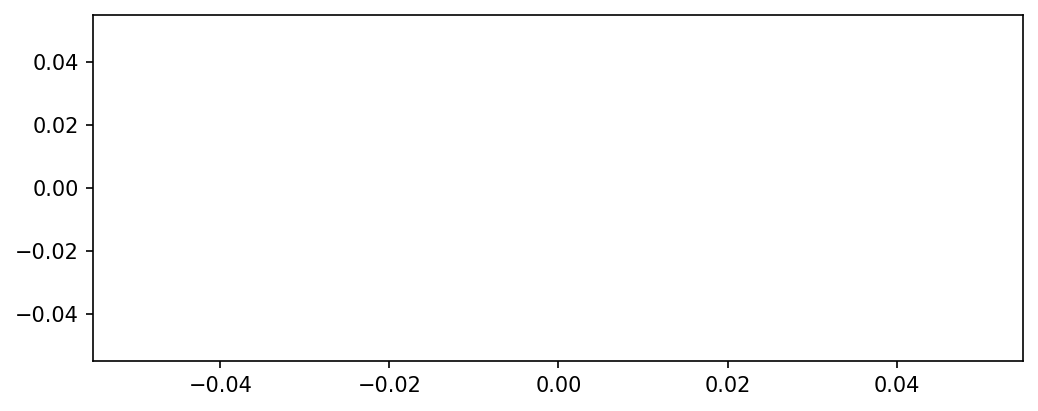

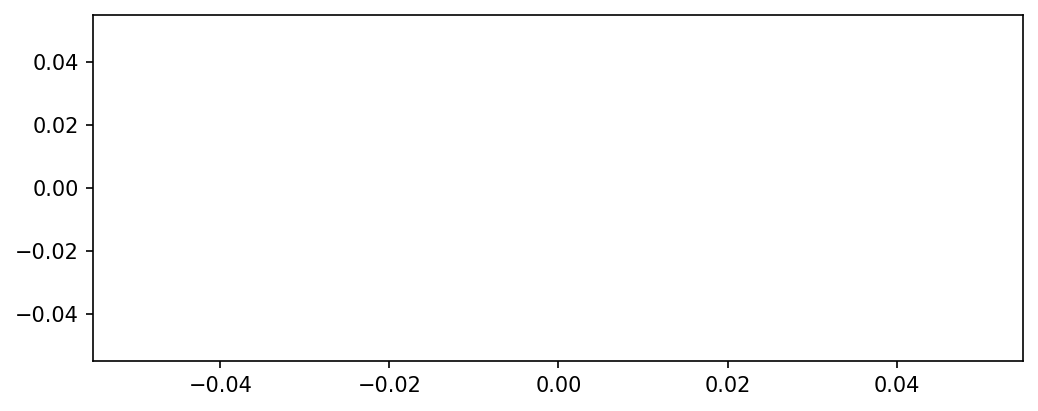

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(probe_losses)
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(test_probe_losses)
plt.show()